In [12]:
import pystan
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

In [14]:
%matplotlib inline

In [50]:
model_code = """
data {
  int N; //the number of observations
  int N2; //the size of the new_X matrix
  int K; //the number of columns in the model matrix
  vector[N] y; //the response
  matrix[N,K] X; //the model matrix
  matrix[N2,K] new_X; //the matrix for the predicted values
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred = X*beta;
}
model {  
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008
  
  y ~ normal(linpred,sigma);
}
generated quantities {
  vector[N2] y_pred;
  y_pred = new_X*beta; //the y values predicted by the model
}
"""

In [52]:
model_name = 'linear_regression'
pkl_file = model_name + '.pkl'

if os.path.isfile(pkl_file):
    # Reuse previously compiled model
    sm = pickle.load(open(pkl_file, 'rb'))
else:
    # Compile and sample model
    sm = pystan.StanModel(model_code=model_code, model_name=model_name)
    with open(pkl_file, 'wb') as f:
        pickle.dump(sm, f)

In [95]:
# Test data
N = 20
beta = np.array([0.2, 1]).reshape((-1,1))
x = np.linspace(0, 1, N).reshape((-1, 1))
X = np.column_stack([np.ones(x.shape), x])
y = X.dot(beta) + np.random.normal(0, 0.1, size=N).reshape((-1, 1))

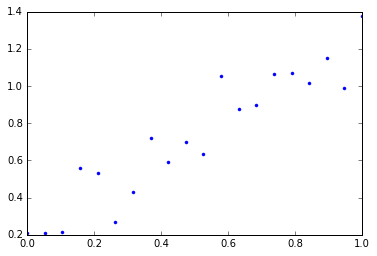

In [96]:
plt.plot(x, y, marker='.', linestyle='none')

In [97]:
# Plot fit
N2 = 2
new_x =  np.linspace(0, 1, N2).reshape((-1, 1))
new_X = np.column_stack([np.ones(N2).reshape((-1, 1)), new_x])

In [98]:
data = {
    'N': N,
    'X': X,
    'K': X.shape[1],
    'y': y.flatten(), 
    'N2': N2,
    'new_X': new_X
}

In [100]:
res = sm.optimizing(data=data)

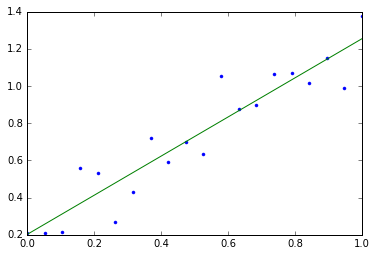

In [101]:
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(new_x, res['y_pred'])
plt.show()

In [109]:
res_vb = sm.vb(data=data, pars=['beta', 'y_pred'])
out_file = res_vb['args']['sample_file']
df = pd.read_csv(out_file, comment='#').iloc[2:, :]

In [110]:
df.describe()

,beta.1,beta.2,sigma,linpred.1,linpred.2,linpred.3,linpred.4,linpred.5,linpred.6,linpred.7,...,linpred.13,linpred.14,linpred.15,linpred.16,linpred.17,linpred.18,linpred.19,linpred.20,y_pred.1,y_pred.2
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,...,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.182844,1.037472,0.125090,0.182844,0.237448,0.292052,0.346656,0.401259,0.455863,0.510467,...,0.838090,0.892693,0.947297,1.001901,1.056505,1.111108,1.165712,1.220316,0.182844,1.220316
std,0.028816,0.052371,0.023049,0.028816,0.028858,0.029162,0.029720,0.030518,0.031536,0.032756,...,0.043158,0.045248,0.047406,0.049624,0.051893,0.054208,0.056562,0.058951,0.028816,0.058951
min,0.096308,0.897003,0.050547,0.096308,0.148523,0.200737,0.252952,0.305166,0.357381,0.409595,...,0.702890,0.751476,0.800061,0.848647,0.897232,0.945818,0.994404,1.042990,0.096308,1.042990
25%,0.162947,1.001870,0.111194,0.162947,0.217033,0.271244,0.325132,0.379805,0.434125,0.488033,...,0.808415,0.861096,0.914539,0.967395,1.020070,1.073350,1.126780,1.179730,0.162947,1.179730
50%,0.182084,1.035710,0.126239,0.182084,0.237030,0.292663,0.346757,0.401530,0.455937,0.509669,...,0.837606,0.891172,0.944999,1.000230,1.054380,1.109480,1.164270,1.219270,0.182084,1.219270
75%,0.202387,1.074250,0.139820,0.202387,0.256616,0.311863,0.367034,0.422163,0.477016,0.532499,...,0.866059,0.922731,0.978623,1.034490,1.090360,1.147200,1.203510,1.259570,0.202387,1.259570
max,0.277034,1.192870,0.198028,0.277034,0.333754,0.392957,0.453495,0.514033,0.574571,0.635109,...,0.998337,1.058880,1.119410,1.179950,1.240490,1.301030,1.361560,1.422100,0.277034,1.422100


In [111]:
df.head()

,lp__,beta.1,beta.2,sigma,linpred.1,linpred.2,linpred.3,linpred.4,linpred.5,linpred.6,...,linpred.13,linpred.14,linpred.15,linpred.16,linpred.17,linpred.18,linpred.19,linpred.20,y_pred.1,y_pred.2
2,0,0.182627,1.036640,0.126258,0.182627,0.237187,0.291747,0.346307,0.400867,0.455427,...,0.837347,0.891907,0.946467,1.001030,1.05559,1.11015,1.16471,1.21927,0.182627,1.21927
3,0,0.214259,0.964094,0.098657,0.214259,0.265001,0.315743,0.366485,0.417226,0.467968,...,0.823161,0.873903,0.924644,0.975386,1.02613,1.07687,1.12761,1.17835,0.214259,1.17835
4,0,0.196433,1.061540,0.150415,0.196433,0.252304,0.308175,0.364045,0.419916,0.475787,...,0.866881,0.922752,0.978623,1.034490,1.09036,1.14623,1.20211,1.25798,0.196433,1.25798
5,0,0.183757,1.042700,0.149629,0.183757,0.238636,0.293515,0.348393,0.403272,0.458151,...,0.842302,0.897181,0.952060,1.006940,1.06182,1.11670,1.17157,1.22645,0.183757,1.22645
6,0,0.202638,1.075620,0.126750,0.202638,0.259250,0.315861,0.372472,0.429084,0.485695,...,0.881975,0.938586,0.995197,1.051810,1.10842,1.16503,1.22164,1.27825,0.202638,1.27825


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0aa322c10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb08db2c990>]], dtype=object)

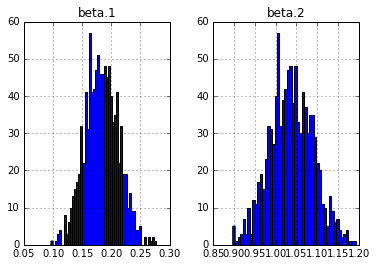

In [113]:
df[['beta.1', 'beta.2']].hist(bins=50)